# Analyze torsions
https://github.com/srnas/barnaba/blob/master/examples/example_04_torsion.ipynb

In [1]:
import os, sys, math
import numpy as np
import glob
import mdtraj
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import warnings

#from openmmtools.multistate import ReplicaExchangeSampler, MultiStateReporter
import openmmtools as mmtools
from pymbar import timeseries
from openmm import *
from openmm.app import *
#from openmm.unit import *

import barnaba as bb
from barnaba import definitions
from barnaba.nucleic import Nucleic

#### define input file

In [2]:
pdb_init = "../../eq/solvated.pdb"
pdb_min = "../../eq/min.pdb"
traj = "../../eq/traj.nc"

In [3]:
_ = mdtraj.load_pdb(pdb_init)
rnames = [ residue.name for residue in _.topology.residues if residue.name not in ["HOH", "NA", "CL"]]
print(rnames)

['C', 'C', 'C', 'C']


#### compare backbone angles for initial and minimized structure

In [4]:
# initial structure

angles, res = bb.backbone_angles(pdb_init)

# print angles
header = "# Residue " + "".join(["%10s " % aa for aa in definitions.bb_angles])
print(header)
for j in range(angles.shape[1]):
    stri = "%10s" % res[j]
    for k in range(angles.shape[2]):
        stri += "%10.3f " % angles[0,j,k]
    print(stri)

# Residue      alpha       beta      gamma      delta        eps       zeta        chi 
     C_1_0       nan        nan      0.852      1.452     -2.563     -1.372     -2.908 
     C_2_0    -1.050      3.053      0.854      1.451     -2.562     -1.373     -2.907 
     C_3_0    -1.050      3.052      0.853      1.452     -2.562     -1.374     -2.908 
     C_4_0    -1.050      3.053      0.853      1.452        nan        nan     -2.908 


# Loading ../../eq/solvated.pdb 


In [5]:
# minimized structure

angles, res = bb.backbone_angles(pdb_min)

# print angles
header = "# Residue " + "".join(["%10s " % aa for aa in definitions.bb_angles])
print(header)
for j in range(angles.shape[1]):
    stri = "%10s" % res[j]
    for k in range(angles.shape[2]):
        stri += "%10.3f " % angles[0,j,k]
    print(stri)

# Residue      alpha       beta      gamma      delta        eps       zeta        chi 
     C_1_0       nan        nan      1.152      1.442     -2.565     -1.343     -2.378 
     C_2_0    -1.433      3.026      1.211      1.443     -2.770     -1.189     -2.578 
     C_3_0    -1.523     -3.125      1.052      1.375     -2.829     -1.241     -2.542 
     C_4_0    -1.313     -3.114      1.073      1.439        nan        nan     -2.667 


# Loading ../../eq/min.pdb 


#### analyze equilibrated trajectory

In [6]:
# define backbone torisons

mydict = {}
mydict["alpha"]=0
mydict["beta"]=1
mydict["gamma"]=2
mydict["delta"]=3
mydict["eps"]=4
mydict["zeta"]=5
mydict["chi"]=6

#### backbone angles

In [7]:
angles_s,res_s = bb.backbone_angles(traj, topology=pdb_init)
print(angles_s.shape)

(110, 4, 7)


# Loading ../../eq/traj.nc 


/lila/home/takabak/mambaforge/envs/espaloma/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


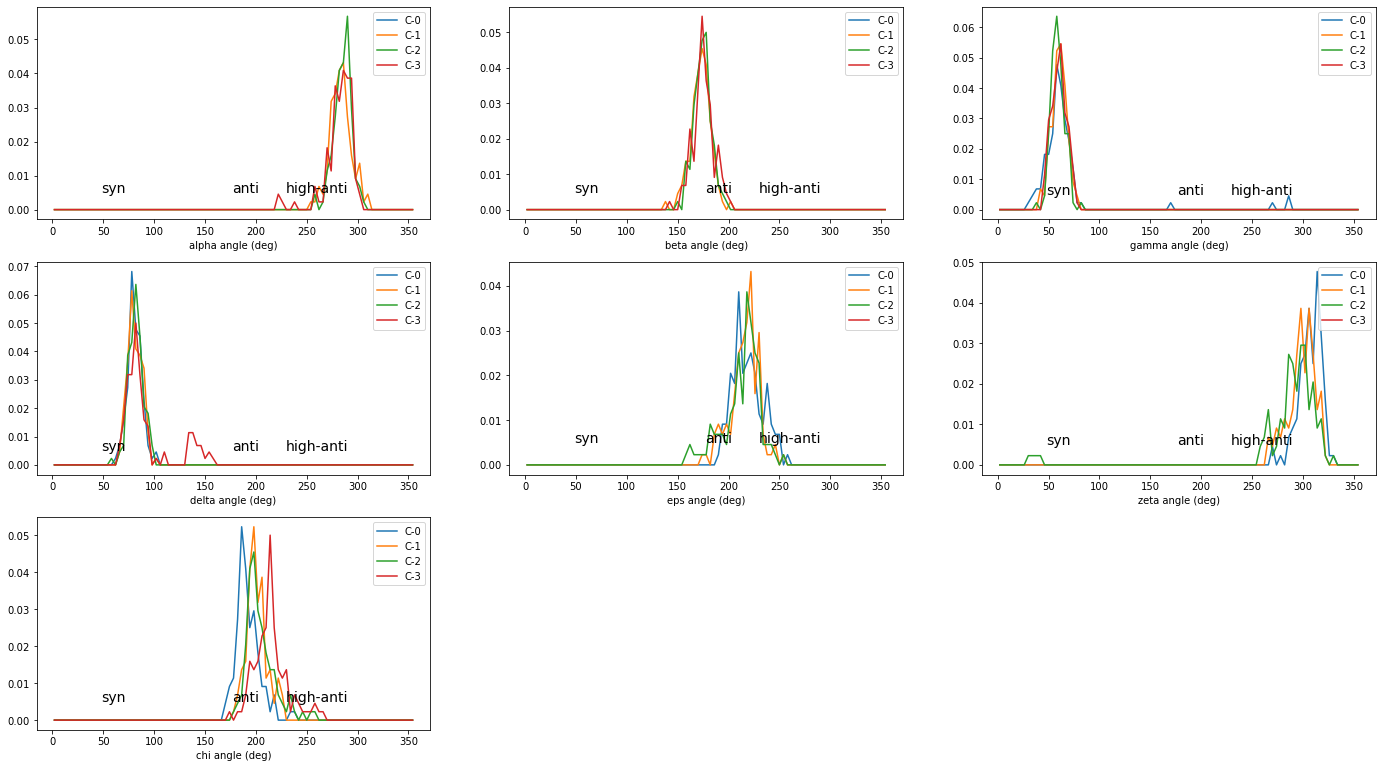

In [8]:
# move from -pi,pi to 0-2pi range
aa = np.copy(angles_s)
aa[np.where(aa<0.0)] += 2.*np.pi


# from radians to deg
aa *= 180.0/np.pi


# create historgram 
bins = np.arange(0,360,4)


# make plot
fig = plt.figure(figsize=(24,18))

for k, v in mydict.items():
    """
    k : torsion name
    v : torsion index
    """
    ax = fig.add_subplot(4, 3, v+1)
    for i in range(len(rnames)):
        """
        i : residue name index
        x : normalized frequency
        y : degree
        """
        y, x = np.histogram(aa[:,i, v], density=True, bins=bins)
        ax.plot(0.5*(x[1:]+x[:-1]), y, label="{}-{}".format(rnames[i], i))
    plt.legend(loc="upper right")
    ax.set_xlabel("{} angle (deg)".format(k))
    plt.text(60, 0.005, "syn", fontsize=14, ha='center')
    plt.text(190, 0.005, "anti", fontsize=14, ha='center')
    plt.text(260, 0.005, "high-anti", fontsize=14, ha='center')

#### sugar pucker

In [9]:
ref_angles, rr = bb.pucker_angles(pdb_init, topology=pdb_init)
print(ref_angles.shape)

(1, 4, 2)


# Loading ../../eq/solvated.pdb 


# Loading ../../eq/traj.nc 


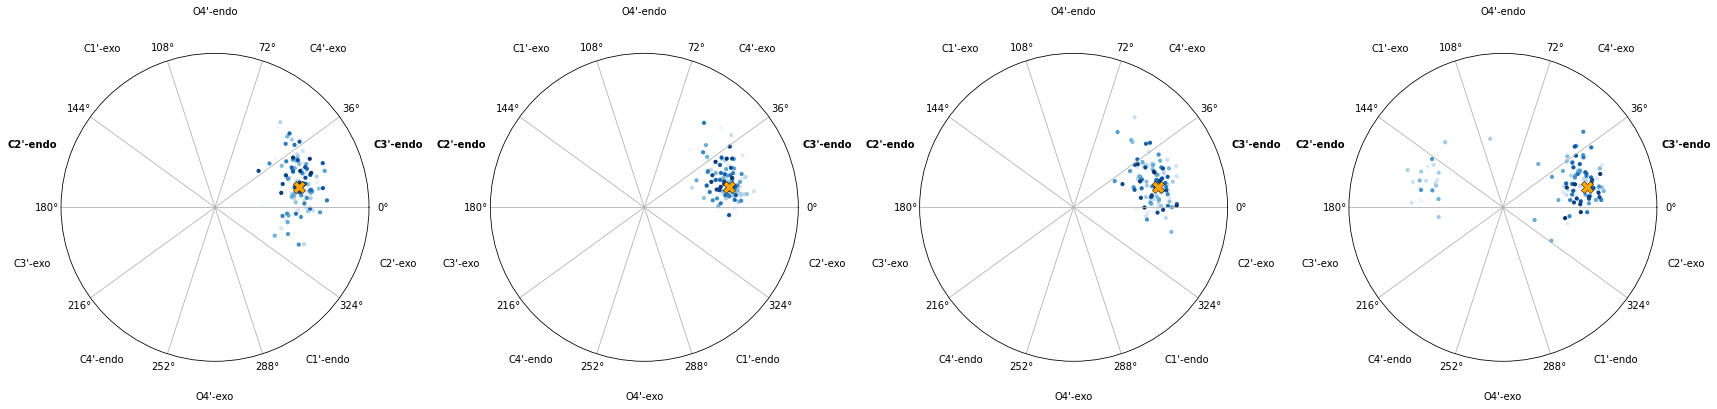

In [10]:
angles, rr = bb.pucker_angles(traj, topology=pdb_init)


# make plot
fig = plt.figure(figsize=(24,18))
for i in range(len(rnames)):
    ax = fig.add_subplot(1, 4, i+1, polar=True)
    #ax.plot(polar=True)

    plt.scatter(angles[:,i,0], angles[:,i,1], s=10, c=np.arange(len(angles)), cmap='Blues', label="{}-{}".format(rnames[i], i))
    plt.scatter(ref_angles[:,i,0], ref_angles[:,i,1], marker="X", c="orange", edgecolors="black", s=150, linewidths=0.5)
    
    p3 = np.pi/5
    plt.ylim(0,1.2)
    xt = np.arange(0,2*np.pi,p3)
    plt.text(0.5*p3,1.5,"C3'-endo",ha='center',fontweight='bold')
    plt.text(1.5*p3,1.5,"C4'-exo",ha='center')
    plt.text(2.5*p3,1.5,"O4'-endo",ha='center')
    plt.text(3.5*p3,1.5,"C1'-exo",ha='center')
    plt.text(4.5*p3,1.5,"C2'-endo",ha='center',fontweight='bold')
    plt.text(5.5*p3,1.5,"C3'-exo",ha='center')
    plt.text(6.5*p3,1.5,"C4'-endo",ha='center')
    plt.text(7.5*p3,1.5,"O4'-exo",ha='center')
    plt.text(8.5*p3,1.5,"C1'-endo",ha='center')
    plt.text(9.5*p3,1.5,"C2'-exo",ha='center')
    plt.xticks(xt)
    plt.yticks([])
    plt.tight_layout()
    #plt.legend(loc="upper center")